# Training Variational Quantum Models with Barren Plateaus Mitigation Strategies
*Training QNN treated with method 3 (Identity Blocks) of the BP mitigation strategy (Cancer)*

**Authors:**
- Jacob Cybulski and Thanh Nguyen


In [1]:
from qiskit.providers.fake_provider import FakeAlmadenV2, FakeSherbrooke
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.primitives import Estimator, BackendEstimator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient
from qiskit_machine_learning.connectors import TorchConnector

import torch
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
import pandas as pd


from Components.train import *
from Components.data import cancer_data
from Components.circuits import *
from Components.gradients import *
from Components.utils import *

from IPython.display import clear_output

seed = 42
np.random.seed(seed)

In [2]:
from os.path import exists
from os import makedirs

In [3]:
# Global config for all experiments (data size, feature dim etc.) is stored here
from GLOBAL_CONFIG import *
# Remember to tag the method
METHOD_TAG = 'm3'

In [4]:
# backend = FakeSherbrooke()
# estimator = BackendEstimator(backend)
# estimator = Estimator()

In [5]:
X_train, X_val, y_train, y_val = cancer_data(PCA_n = FEATURE_DIM)
# X_train, X_val, y_train, y_val = fetch_mnist(PCA_n = FEATURE_DIM, data_size=DATA_SIZE)
# X_train, X_val, y_train, y_val = iris(pd=False, PCA_n=None)

X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

Training set: 398 samples
Testing set: 171 samples
Number of features: 4
PCA Explained variance: [4.43782605e+05 7.31010006e+03 7.03833742e+02 5.46487379e+01]
Classes:[0 1]; Encoded as: [-1  1]


In [6]:
if (exists(f'{LOG_PATH}/{METHOD_TAG}')):
    print(f'Found save folder: {LOG_PATH}/{METHOD_TAG}\n')
# else:
#     makedirs(f'{LOG_PATH}/{METHOD_TAG}')
#     print(f'Creating save folder: {LOG_PATH}/{METHOD_TAG}\n')

Found save folder: ./Logs-Cancer-v4/m3



### Load data / either from the standard Log or a temporary location Logs-Temp

In [7]:
path3 = pd.read_csv(f'{LOG_PATH}/{METHOD_TAG}/{METHOD_TAG}-3-Weights.csv', index_col=0)
path3[path3.shape[1]] = pd.read_csv(f'{LOG_PATH}/{METHOD_TAG}/{METHOD_TAG}-3-LossFunction.csv', index_col=0)
path3 = path3.transpose().reset_index(drop=True).transpose()

# surface3 = pd.read_csv(f'{LOG_PATH}/{METHOD_TAG}/LossFunctionSurface.csv', index_col=0) # Original
surface3 = pd.read_csv(f'Logs-Temp/{METHOD_TAG}/LossFunctionSurface-{2000}.csv', index_col=0) # Temporary for testing

surface3 = surface3.transpose().reset_index(drop=True).transpose()

## Cost Function Surface

In [8]:
feature_map = featureMapGenerator(FEATURE_DIM)
identity_block = preTrainedBlockGenerator(MAX_QUBITS_CLASSIFICATION, MAX_IDENTITIES_BLOCKS, overlay=IDENTITY_BLOCKS_OVERLAY, entanglement=ENTANGLEMENT, insert_barriers=True)
ansatz = identity_block['circuit']
qc=circuitBuilder(feature_map, ansatz)


id_dict = {k.name : v for k, v in identity_block['params_values'].items()}
initial_point = [id_dict[p.name] for p in list(ansatz.parameters)]

In [9]:
### Find what devices are available
from qiskit_aer.backends import AerSimulator
devices = AerSimulator().available_devices()
devices

### Force CPU - PyTorch+Qiskit too slow with GPU
# devices = ('CPU')
# devices

('CPU', 'GPU')

In [10]:
from qiskit.primitives import Estimator # For "CPU", ignores device="GPU" option
from qiskit_aer.primitives import Estimator as AerEstimator # For device="GPU" option

seed = 2023

# Use GPU when present, otherwise CPU
if 'GPU' in devices:
    device = 'GPU'
    estimator = AerEstimator(
        backend_options={'seed_simulator': seed, 'method': 'statevector', 
                         'device' : device, 'cuStateVec_enable' : True},
        run_options={'seed': seed, 'shots': 1000},
        transpile_options={"seed_transpiler": seed},
    )
else:
    device = 'CPU'
    estimator = Estimator()
    estimator.set_options(method='statevector')
    estimator.set_options(device=device)
    estimator.set_options(seed=seed)
    estimator.options

print(f'Selected device: {device}')

Selected device: GPU


### Generation of surface points
To ensure that the cost function surface of the trained model surrounds the optimisation curve (path)<br/>
the random perturbations are added to each cost point of the optimisation curve.

In [ ]:
res = pd.DataFrame()
epochs = 20
perturb = np.pi/2

start = time.time()
for i in range(0, epochs):

    for path_pt in range(path3.shape[0]):
        print(f'iteration: {i}, point: {path_pt}')
        display(res.tail())
        opt_point = np.array(path3)[path_pt][0:-1]
        point_perturb = np.random.uniform(-perturb, perturb, ansatz.num_parameters)
        point = opt_point+point_perturb
        
        qnn = EstimatorQNN(
            circuit=qc,
            estimator=estimator,
            observables=GLOBAL_OPERATOR,
            input_params=feature_map.parameters,
            weight_params=ansatz.parameters
        )
    
        model = TorchConnector(qnn, initial_weights=point)
    
        loss_function = nn.L1Loss() #This is MAE loss
        optimizer = torch.optim.NAdam(model.parameters(), lr=0.05)
    
        loss, weight = sampleWeightLoss(
            model, 
            X_train_t,
            y_train_t,
            optimizer = optimizer, 
            loss_function = loss_function
            )
        res = pd.concat([res, pd.DataFrame(np.append(weight.numpy(), loss.numpy())).transpose()], ignore_index=True) 
        clear_output(wait=True)
elapsed = time.time() - start

surface3 = res

### Save surface data in a temporary location

In [ ]:
# pd.DataFrame(res).astype('float').to_csv(f'Logs-Temp/{METHOD_TAG}/LossFunctionSurface-{surface3.shape[0]}.csv')

### Plot the 3D surface

In [ ]:
# Print run statistics
print(f'{device} Fit\n'+
      f'\tQubits:\t\t{ansatz.num_qubits}\n'+
      f'\tDepth:\t\t{ansatz.depth()} (gates)\n'+
      f'\tWeights:\t{len(ansatz.parameters)} (parameters)\n'+
      f'\tEpochs:\t\t{epochs}\n'+
      f'\tTime:\t\t{elapsed:0.2f} sec')

In [19]:
from sklearn.decomposition import PCA

def plotSurface(surface:pd.DataFrame, path=None, title = '', save:str = None, dpi = 80, pcs=(0, 1), pc_max=2, plot_path=True):
    '''
    use %matplotlib widget for interative plot!
    '''
    if path is not None:
        data = pd.concat([surface, path], ignore_index=True)
    else:
        data = surface

    parameters = data.iloc[:,:-1]
    zValue = data.iloc[:,-1]
    pca = PCA(n_components=pc_max)
    pca.fit(parameters)
    principalSurfaceData = pca.transform(parameters)
    print(f'Explained Variance Ratio: {pca.explained_variance_ratio_}')
    
    principalSurfaceDataDF = pd.DataFrame()
    principalSurfaceDataDF['x'] = principalSurfaceData[:, pcs[0]]
    principalSurfaceDataDF['y'] = principalSurfaceData[:, pcs[1]]
    principalSurfaceDataDF['z'] = zValue
    
    from mpl_toolkits.mplot3d import Axes3D
    surfaceXs = principalSurfaceDataDF['x']
    surfaceYs = principalSurfaceDataDF['y']
    surfaceZs = principalSurfaceDataDF['z']
    
    fig = plt.figure(figsize=(10, 10), dpi=dpi)
    ax = fig.add_subplot(111, projection='3d')
    
    ax.set_xlabel(f'Params PC{pcs[0]+1}')
    ax.set_ylabel(f'Params PC{pcs[1]+1}')
    ax.set_zlabel('Means Absolute Error')
    ax.set_title(title)
    
    plot = ax.plot_trisurf(surfaceXs,
                       surfaceYs,
                       surfaceZs,
                       cmap=plt.get_cmap('rainbow_r'),
                       linewidth=1,
                       antialiased=False,
                       alpha=0.6)
    
    plt.colorbar(plot, shrink=0.5, aspect=5)

    if path is not None and plot_path:
        pathParameters = path.iloc[:,:-1]
        pathZvalue = path.iloc[:,-1]
        principalPathData = pca.transform(pathParameters)
        principalPathDataDF = pd.DataFrame()
        principalPathDataDF['x'] = principalPathData[:, pcs[0]]
        principalPathDataDF['y'] = principalPathData[:, pcs[1]]
        principalPathDataDF['z'] = pathZvalue
        
        ax.plot3D(principalPathDataDF['x'],
                principalPathDataDF['y'],
                principalPathDataDF['z'],
                color='red',
                linewidth=3,
                antialiased=False,
                alpha=1)

    plt.show()

    if save:
        plt.savefig(save)


Explained Variance Ratio: [0.01593212 0.01316343 0.0129694  0.01256321 0.01247564 0.01236693
 0.01207776 0.01188392 0.01172068 0.01158981]


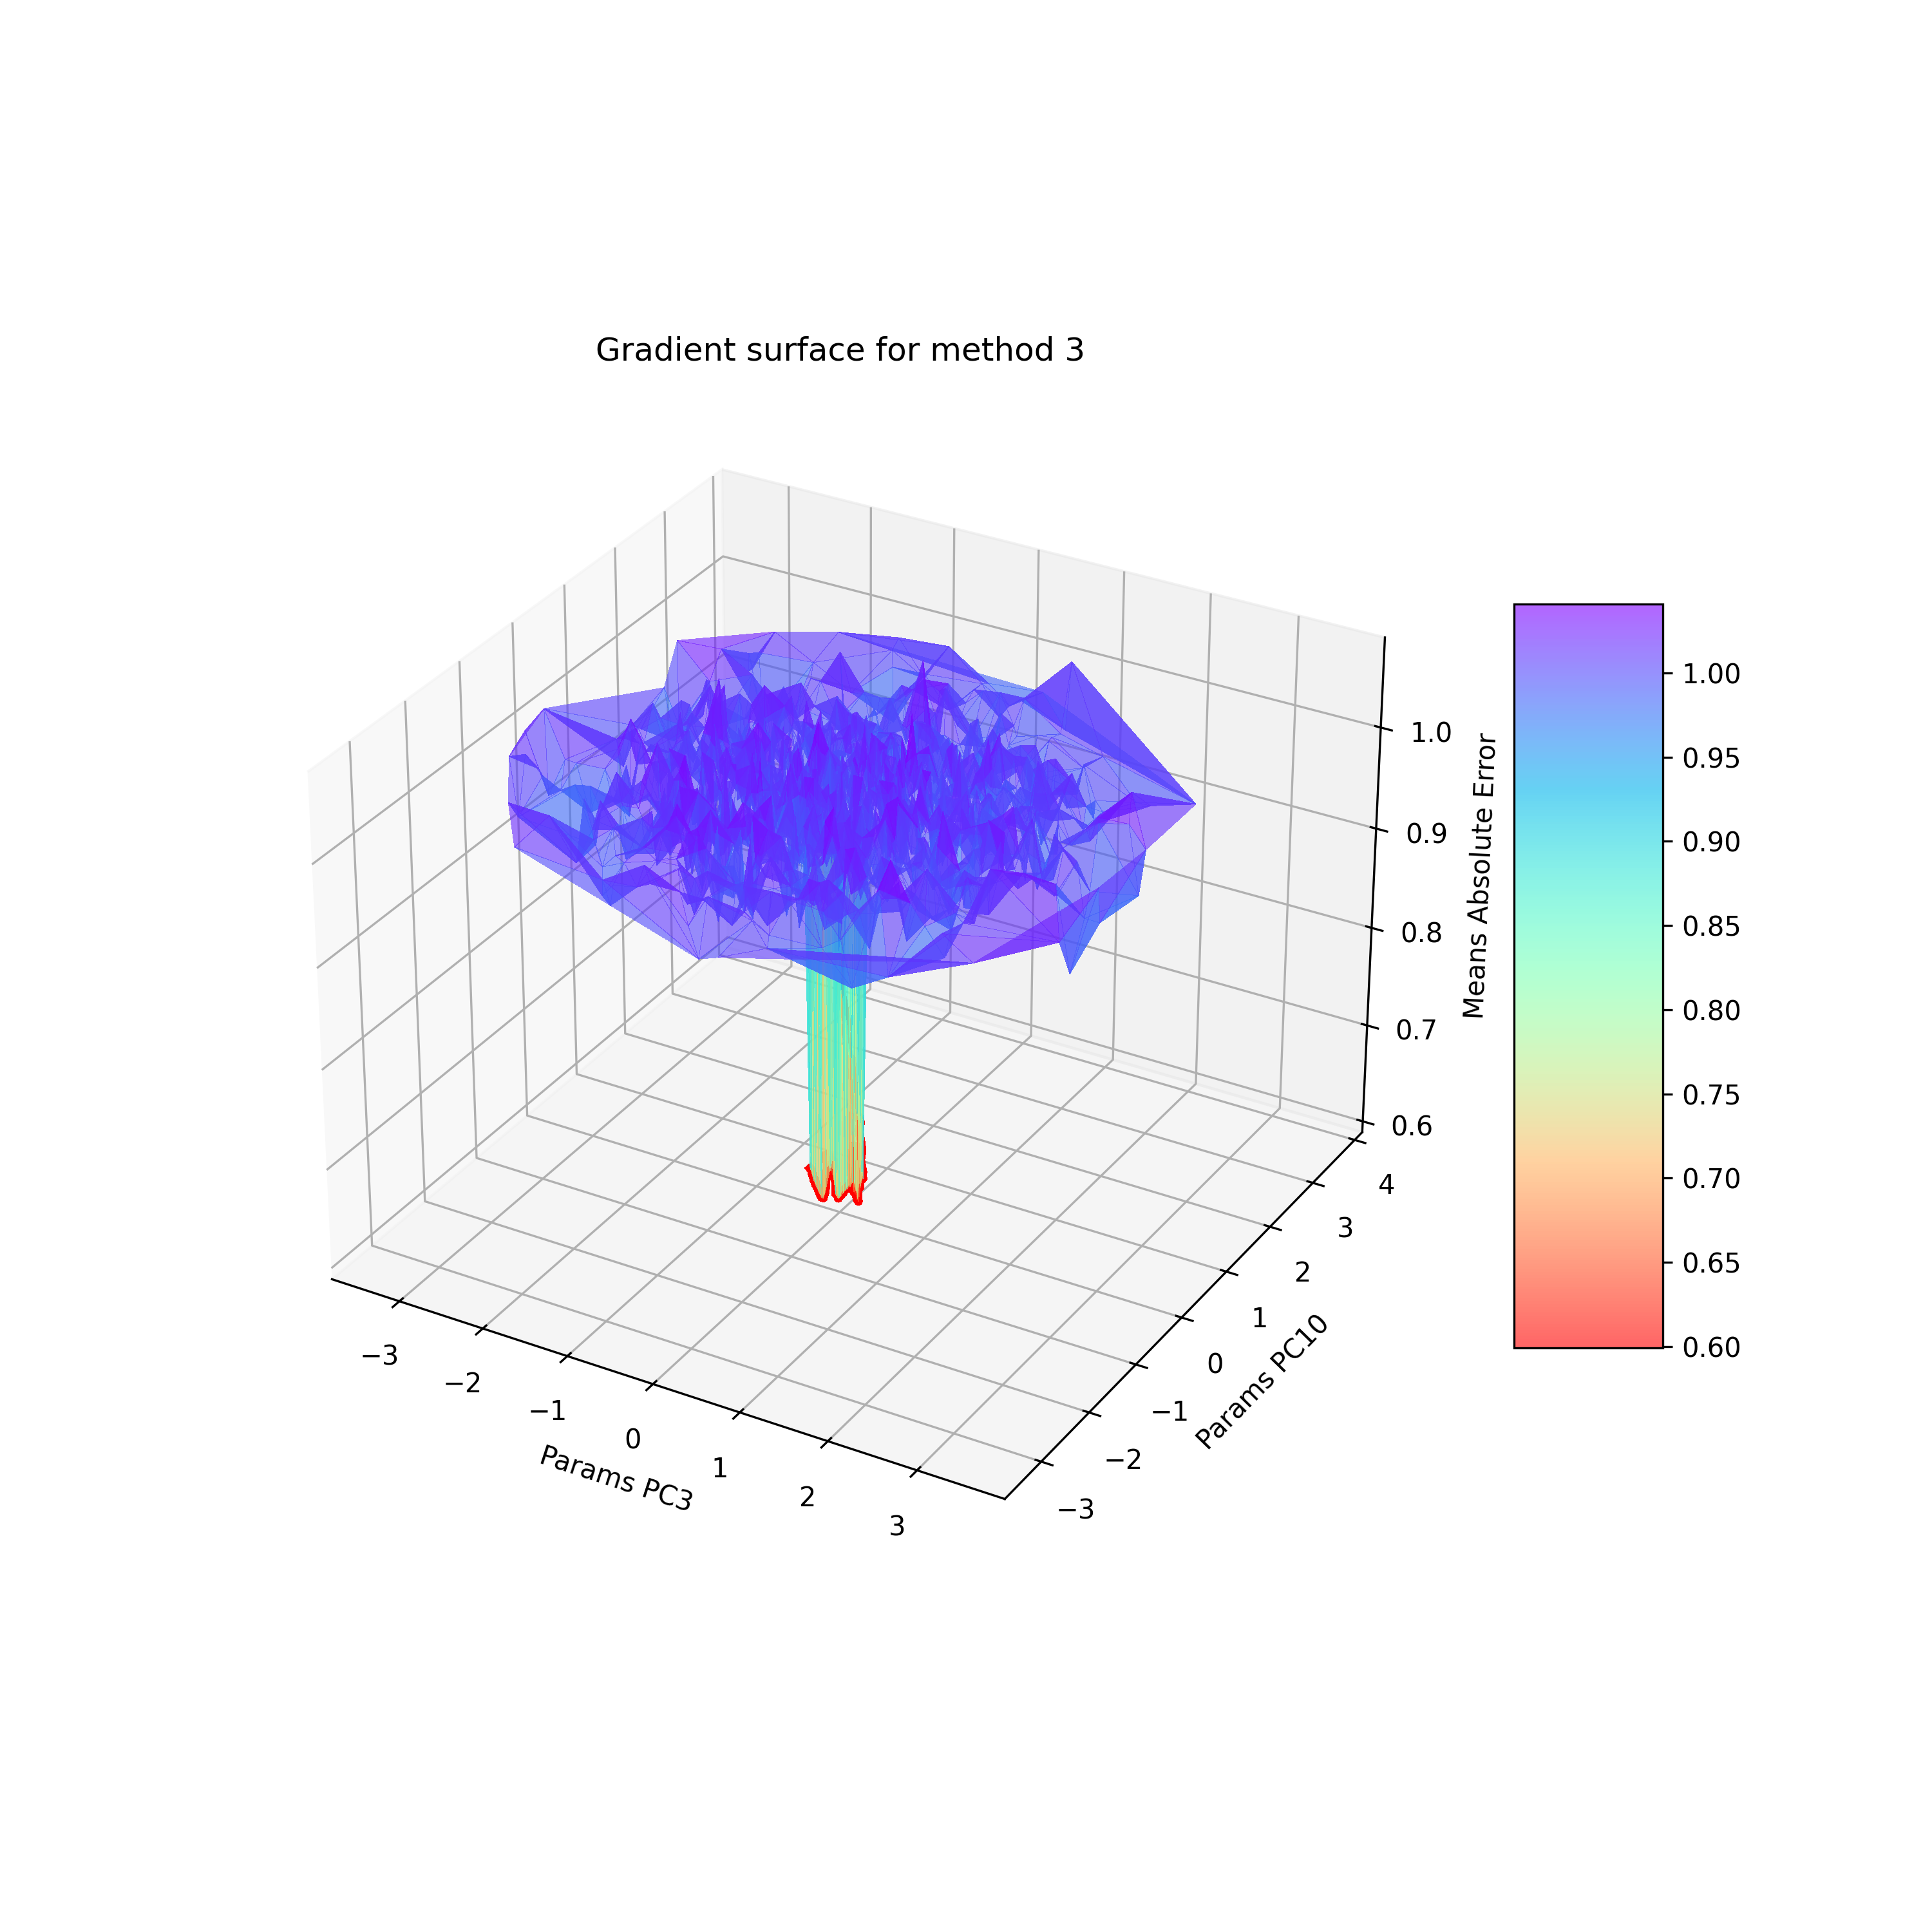

In [20]:
%matplotlib widget
plotSurface(surface3, path=path3, title='Gradient surface for method 3', dpi=300, save='m3.png', pc_max=10, pcs=(2, 9), plot_path=True)

In [21]:
!pip list | grep qiskit

qiskit                        0.45.2
qiskit-aer-gpu                0.13.2
qiskit-algorithms             0.2.2
qiskit-dynamics               0.4.3
qiskit-finance                0.4.0
qiskit-ibm-provider           0.6.3
qiskit-ibm-runtime            0.11.3
qiskit-ibmq-provider          0.20.2
qiskit-machine-learning       0.7.1
qiskit-nature                 0.7.1
qiskit-optimization           0.6.0
qiskit-qasm3-import           0.4.1
qiskit-sphinx-theme           1.12.1
qiskit-terra                  0.45.2


In [22]:
!pip list | grep torch

torch                         2.1.0
torchaudio                    2.1.0
torchsummary                  1.5.1
torchvision                   0.16.0
